# Predicting student AI reuse from session data

### Overview

This dataset contains 10,000 data from sessions in which students from various disciplines used the AI assistant.

Columns include:


- StudentLevel – Education level (Undergraduate, Graduate, Highschool)
- Discipline – Field of study
- SessionLengthMin – Duration of the session in minutes
- TotalPrompts – Number of prompts submitted
- TaskType – Type of task (Studying, Coding, Writing, etc.)
- AI_AssistanceLevel – Numerical level of assistance provided by the AI (1 to 5)
- FinalOutcome – Outcome of the task 
- UsedAgain – Whether the student reused the AI assistant (TARGET)
- SatisfactionRating – Student satisfaction score (1 to 5)
- Gender –  Male or female

### Project aim

The objective is to predict whether a student will reuse the AI assistant in the future based on their session data and overall experience

This is a binary classification problem, where:

- True => Student reused the AI assistant

- False => Student did not reuse the AI assistant

### Importing and Installing libraries

In [1]:
!pip install missingno==0.5.2


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 129.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate,
     RandomizedSearchCV, RepeatedStratifiedKFold,
    learning_curve
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

from imblearn.over_sampling import SMOTENC, RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline


### Dataset loading

I uploaded the dataset with pandas and inspected it.

In [4]:
dataset = pd.read_csv("ai_assistant_usage_student.csv")

In [5]:
dataset

,SessionID,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,SESSION00001,Undergraduate,Computer Science,2024-11-03,31.20,11,Studying,2,Assignment Completed,True,1.0,female
1,SESSION00002,Undergraduate,Psychology,2024-08-25,13.09,6,Studying,3,Assignment Completed,True,2.0,male
2,SESSION00003,Undergraduate,Business,2025-01-12,19.22,5,Coding,3,Assignment Completed,True,3.3,female
3,SESSION00004,Undergraduate,Computer Science,2025-05-06,3.70,1,Coding,3,Assignment Completed,True,3.5,female
4,SESSION00005,Undergraduate,Psychology,2025-03-18,28.12,9,Writing,3,Assignment Completed,True,2.9,female
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,SESSION09996,Undergraduate,Psychology,2024-07-20,28.41,5,Studying,3,Assignment Completed,True,4.2,male
9996,SESSION09997,High School,Business,2024-11-11,13.98,6,Writing,5,Assignment Completed,True,5.0,female
9997,SESSION09998,Undergraduate,Biology,2024-09-11,10.78,2,Studying,3,Idea Drafted,True,3.5,male
9998,SESSION09999,Undergraduate,Business,2024-10-27,30.88,7,Writing,3,Assignment Completed,False,4.3,male


## Preliminary selection

Before modeling, I decided to remove 2 columns because they were not useful for the analysis:

- SessionID is only a unique identifier for the row, it does not contain information useful for prediction and could even introduce noise if encoded.

- SessionDate is a specific date that, as it stands, has no direct significance for predicting UsedAgain. (It could only become useful if transformed into temporal variables (month, day, season), but it is not relevant to the current objective).

In [6]:
dataset = dataset.drop(columns=["SessionID", "SessionDate"])
dataset


,StudentLevel,Discipline,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,Undergraduate,Computer Science,31.20,11,Studying,2,Assignment Completed,True,1.0,female
1,Undergraduate,Psychology,13.09,6,Studying,3,Assignment Completed,True,2.0,male
2,Undergraduate,Business,19.22,5,Coding,3,Assignment Completed,True,3.3,female
3,Undergraduate,Computer Science,3.70,1,Coding,3,Assignment Completed,True,3.5,female
4,Undergraduate,Psychology,28.12,9,Writing,3,Assignment Completed,True,2.9,female
...,...,...,...,...,...,...,...,...,...,...
9995,Undergraduate,Psychology,28.41,5,Studying,3,Assignment Completed,True,4.2,male
9996,High School,Business,13.98,6,Writing,5,Assignment Completed,True,5.0,female
9997,Undergraduate,Biology,10.78,2,Studying,3,Idea Drafted,True,3.5,male
9998,Undergraduate,Business,30.88,7,Writing,3,Assignment Completed,False,4.3,male


With this block i displayed general information about the data in the dataset and a preliminary analysis on missing values.

In [7]:
# Summary of all columns
print("Data types and missing values:\n")
dataset.info()

Data types and missing values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   StudentLevel        10000 non-null  object 
 1   Discipline          10000 non-null  object 
 2   SessionLengthMin    10000 non-null  float64
 3   TotalPrompts        10000 non-null  int64  
 4   TaskType            10000 non-null  object 
 5   AI_AssistanceLevel  10000 non-null  int64  
 6   FinalOutcome        10000 non-null  object 
 7   UsedAgain           10000 non-null  bool   
 8   SatisfactionRating  10000 non-null  float64
 9   Gender              10000 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 713.0+ KB


The line print(dataset.dtypes) displays the data type of each column in the dataset DataFrame.

In [8]:
print(dataset.dtypes)

StudentLevel           object
Discipline             object
SessionLengthMin      float64
TotalPrompts            int64
TaskType               object
AI_AssistanceLevel      int64
FinalOutcome           object
UsedAgain                bool
SatisfactionRating    float64
Gender                 object
dtype: object


### Data Visualization

In [9]:
# List on numerical columns
numerical_columns = dataset.select_dtypes(include=["float64", "int64"]).columns.tolist()

dataset[numerical_columns].describe()

,SessionLengthMin,TotalPrompts,AI_AssistanceLevel,SatisfactionRating
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,19.846467,5.607500,3.479500,3.417780
std,13.897302,4.648764,0.991805,1.143331
min,0.030000,1.000000,1.000000,1.000000
25%,9.630000,2.000000,3.000000,2.600000
50%,16.650000,4.000000,4.000000,3.500000
75%,26.670000,8.000000,4.000000,4.400000
max,110.810000,39.000000,5.000000,5.000000


With this bar chart, I visualized the distribution of the target variable UsedAgain. 

/tmp/ipykernel_44/3225708371.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="UsedAgain", data=dataset, palette="pastel")


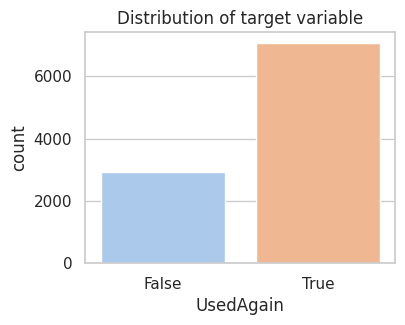

In [10]:
sns.set(style="whitegrid")

plt.figure(figsize=(4,3))
sns.countplot(x="UsedAgain", data=dataset, palette="pastel")
plt.title("Distribution of target variable")
plt.show()

It is clear that the target  is unbalanced: class "True" is much more frequent than class "False"

### Correlation matrix

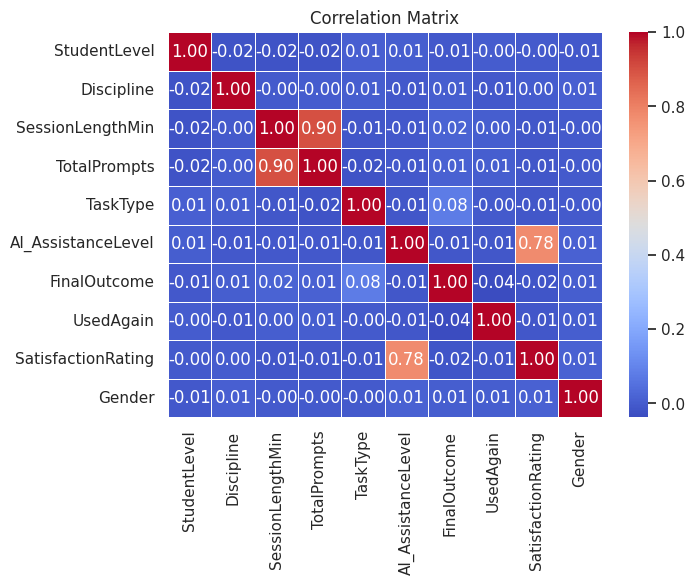

In [11]:
df_corr = dataset.copy()
categorical_columns = df_corr.select_dtypes(include=["object"]).columns.tolist()

# label encoding for each category
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_corr[col] = label_encoder.fit_transform(df_corr[col])

corr_matrix = df_corr.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Correlation Matrix")
plt.show()

From the correlation matrix I noticed that there are 2 features which have very high correlation (0.9): SessionLengthMin and TotalPrompts. Keeping both may not add any real information and increase noise, but I decided to drop one of the two.

To better take this decision, I calculated the direct correlation with the target and noticed that neither stands out as more predictive.

In [12]:
corr_with_target = dataset[["SessionLengthMin", "TotalPrompts", "UsedAgain"]].corr()["UsedAgain"].drop("UsedAgain")
print(corr_with_target)


SessionLengthMin    0.004908
TotalPrompts        0.006690
Name: UsedAgain, dtype: float64


Thus, I decided to keep TotalPrompts because it  is an integer count and directly represents interaction with the AI, while SessionLengthMin is a more “noisy” measure of time (decimals, possible variations due to inactivity).

In [13]:
dataset = dataset.drop(columns=["SessionLengthMin"])
dataset

,StudentLevel,Discipline,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,Undergraduate,Computer Science,11,Studying,2,Assignment Completed,True,1.0,female
1,Undergraduate,Psychology,6,Studying,3,Assignment Completed,True,2.0,male
2,Undergraduate,Business,5,Coding,3,Assignment Completed,True,3.3,female
3,Undergraduate,Computer Science,1,Coding,3,Assignment Completed,True,3.5,female
4,Undergraduate,Psychology,9,Writing,3,Assignment Completed,True,2.9,female
...,...,...,...,...,...,...,...,...,...
9995,Undergraduate,Psychology,5,Studying,3,Assignment Completed,True,4.2,male
9996,High School,Business,6,Writing,5,Assignment Completed,True,5.0,female
9997,Undergraduate,Biology,2,Studying,3,Idea Drafted,True,3.5,male
9998,Undergraduate,Business,7,Writing,3,Assignment Completed,False,4.3,male


### Handling Missing Value

The original dataset was clean, so I intentionally introduced missing values to simulate the imperfections of real data. In this way, the model can be tested under more realistic conditions, ensuring that it can effectively handle incomplete data and improving its robustness in practical applications.

In [14]:
dataset.isnull()

,StudentLevel,Discipline,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False


In [15]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X.iloc[indexes] = np.nan
    return X

In [16]:
dataset['TotalPrompts'] = add_missing(dataset['TotalPrompts'], 0.21)  
dataset['Discipline'] = add_missing(dataset['Discipline'], 0.17)  
dataset['SatisfactionRating'] = add_missing(dataset['SatisfactionRating'], 0.11)  
dataset['Gender'] = add_missing(dataset['Gender'], 0.09)  

# Verifica valori NaN introdotti
dataset.isnull().sum()

StudentLevel             0
Discipline            1700
TotalPrompts          2100
TaskType                 0
AI_AssistanceLevel       0
FinalOutcome             0
UsedAgain                0
SatisfactionRating    1100
Gender                 900
dtype: int64

I added random missing values to:

- TotalPrompts 

- Discipline 

- SatisfactionRating 

- Gender

In [17]:
dataset

,StudentLevel,Discipline,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,Undergraduate,Computer Science,11.0,Studying,2,Assignment Completed,True,1.0,female
1,Undergraduate,Psychology,6.0,Studying,3,Assignment Completed,True,2.0,male
2,Undergraduate,Business,NaN,Coding,3,Assignment Completed,True,3.3,female
3,Undergraduate,Computer Science,NaN,Coding,3,Assignment Completed,True,3.5,female
4,Undergraduate,Psychology,9.0,Writing,3,Assignment Completed,True,2.9,NaN
...,...,...,...,...,...,...,...,...,...
9995,Undergraduate,Psychology,5.0,Studying,3,Assignment Completed,True,4.2,male
9996,High School,Business,6.0,Writing,5,Assignment Completed,True,5.0,female
9997,Undergraduate,Biology,2.0,Studying,3,Idea Drafted,True,NaN,male
9998,Undergraduate,Business,NaN,Writing,3,Assignment Completed,False,4.3,male


In [18]:
dataset.isnull()

,StudentLevel,Discipline,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating,Gender
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,True,False
9998,False,False,True,False,False,False,False,False,False


Visualization of missing values in the dataset and their distribution pattern.

<AxesSubplot: >

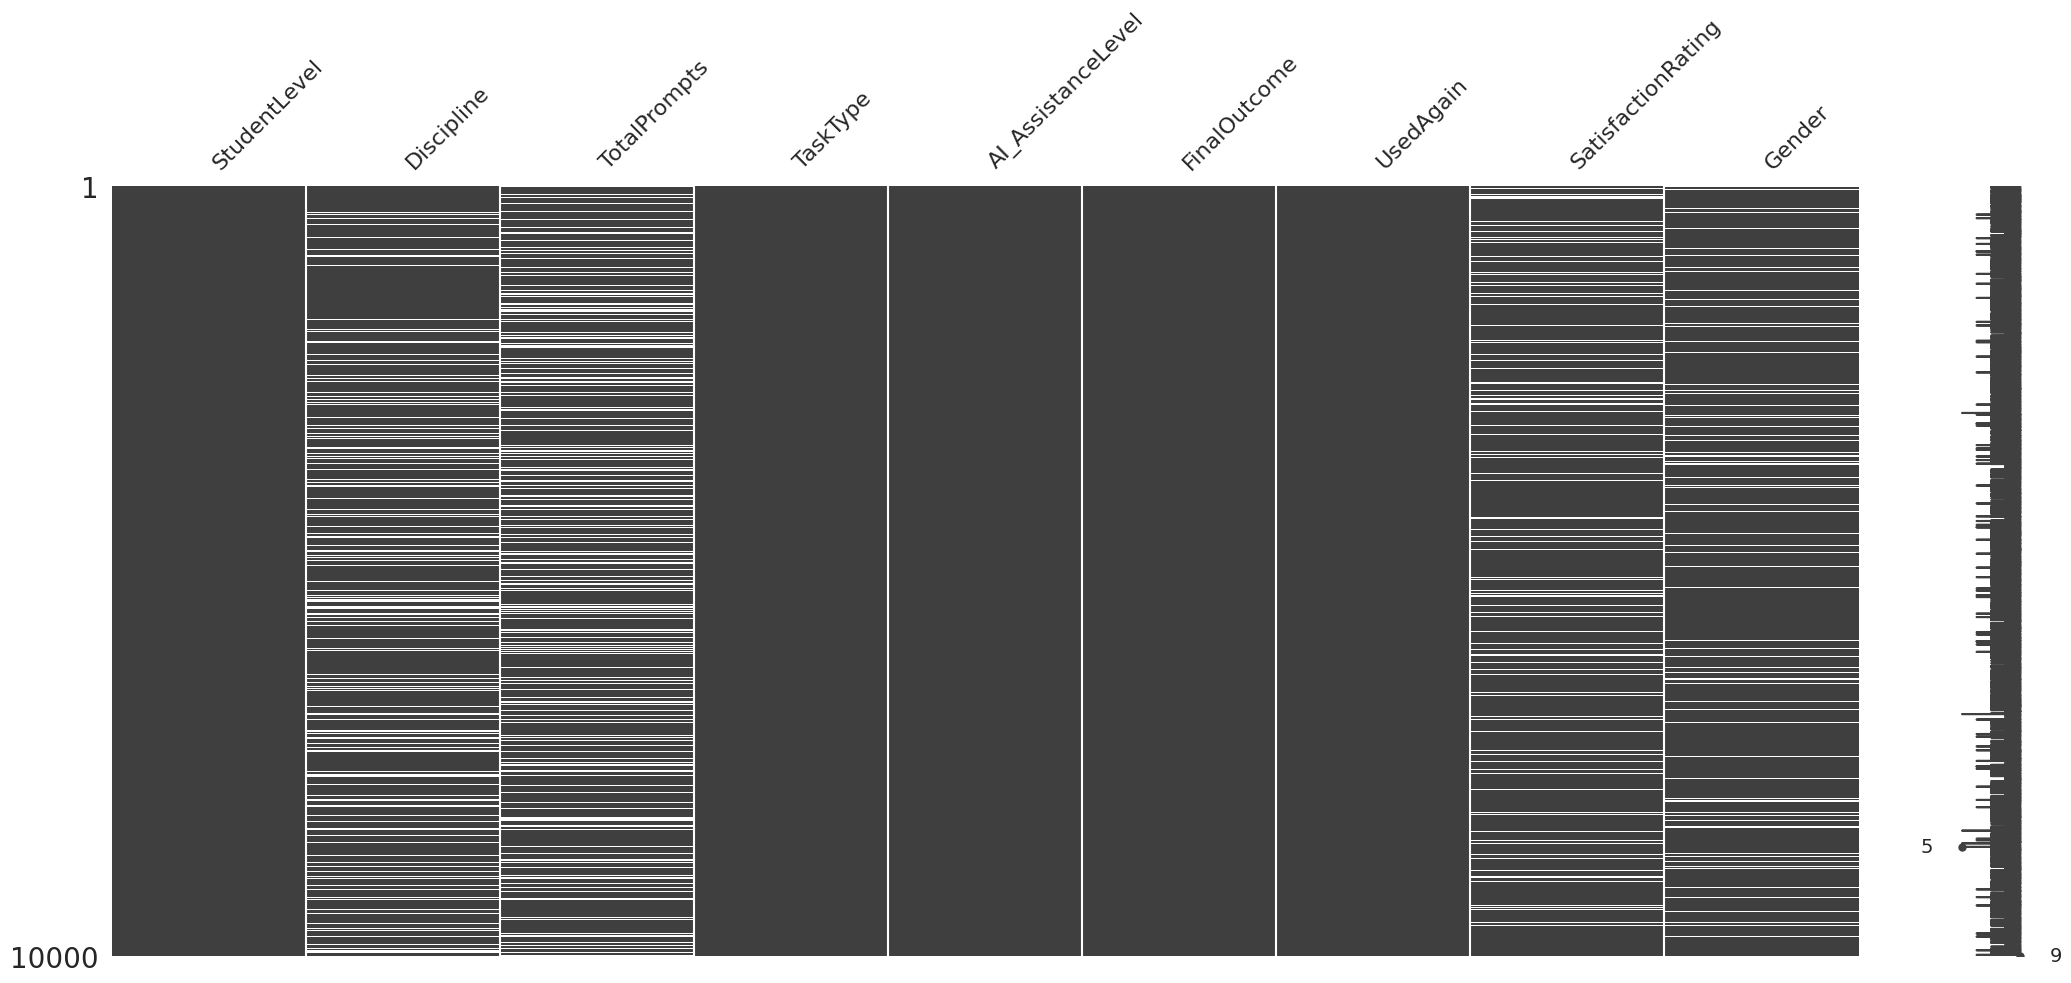

In [19]:
X = dataset
msno.matrix(X) 

### Preprocessing Data

To prepare data, I initially divided them into categories, to better handle them:

1. Numerical features

        - TotalPrompts

        - SatisfactionRating

        - AI_AssistanceLevel

2. Categorical Ordinal features

        - StudentLevel 

3. Categorical Nominal features:

        - Discipline

        - Gender 

        - TaskType

        - FinalOutcome 

In [20]:
X = dataset.drop(columns=["UsedAgain"])
y = dataset["UsedAgain"]

# Check
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Colonne di X:", X.columns.tolist())

Shape X: (10000, 8)
Shape y: (10000,)
Colonne di X: ['StudentLevel', 'Discipline', 'TotalPrompts', 'TaskType', 'AI_AssistanceLevel', 'FinalOutcome', 'SatisfactionRating', 'Gender']


<img src="image-20250811-174311.png" width="" align="" />

In [ ]:
numerical_missing = ["TotalPrompts", "SatisfactionRating"]    #KNN + StandardScaler
numerical_nomissing = ["AI_AssistanceLevel"]       #StandardScaler

ordinal_nomissing = ["StudentLevel"]    #OrdinalEncoder
student_level_order = ["High School", "Undergraduate", "Graduate"]     #give a real order

nominal_missing = ["Discipline", "Gender"]        #SimpleImputer + OneHotEncoder
nominal_nomissing = [ "TaskType", "FinalOutcome"]   #OneHotEncoder

I divided the features into groups, treating each one in a manner consistent with the nature of the data. For example, on numerical variables with missing values such as TotalPrompts, I applied KNNImputer followed by StandardScaler, while on ordinal variables such as StudentLevel, I used OrdinalEncoder. For nominal categorical variables with missing values, such as Disciplines, I performed simple imputer and then one-hot encoder. Each group had its own mini-pipeline, so as to keep the preprocessing modular and reproducible.

In [22]:
num_missing_pip = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights="distance")),
    ("scaler", StandardScaler()),
])

num_nomissing_pip = Pipeline([
    ("scaler", StandardScaler()),
])

ord_nomissing_pip = Pipeline([
    ("encoder", OrdinalEncoder(categories=[student_level_order],
    handle_unknown="use_encoded_value", unknown_value=-1)),
])

nom_missing_pip = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

nom_nomissing_pip = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

This preprocessor is a ColumnTransformer that applies different pipelines to each feature group. Numerical, ordinal, and nominal variables are split depending on whether they contain missing values, so the appropriate imputation and encoding steps can be applied.

In [23]:
preprocessor = ColumnTransformer([
    ("num_missing", num_missing_pip, numerical_missing),
    ("num_nomissing", num_nomissing_pip, numerical_nomissing),
    ("ord_nomissing", ord_nomissing_pip, ordinal_nomissing),
    ("nom_missing", nom_missing_pip, nominal_missing),
    ("nom_nomissing", nom_nomissing_pip, nominal_nomissing)
], remainder="drop")

### Training & Test 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42, shuffle=True)

- test_size = 0.2 => 20% of the dataset goes into the test set and 80% into training.

- random_state = 42 => used for reproducibility; without it, each execution would create a different train/test split

- stratify = y =>  it ensures that in the train and test, the proportion between True/False of UsedAgain remains the same as in the original dataset (71% / 29%), avoiding random imbalances.

## Model selection

Model selection in this context means exploring different pipeline configurations to identify the best-performing combination of components. The base pipeline includes preprocessing, a resampling method, an optional dimensionality reduction step, and a classifier.

I built a complete pipeline with preprocessing, sampling, and modeling. For sampling, I initially used SMOTE to balance the minority class, while for dimensionality reduction we used PCA, keeping only the components that explained at least 80% of the variance. 

In [25]:
model_pipeline = IMBPipeline([
    ("trans", preprocessor),
    ("sampler", SMOTE(k_neighbors=3, random_state=42)),  #default value
    ("dim_reduction", PCA(n_components=0.8)),
    ("classifier", LogisticRegression(max_iter=500))
])

I choose Logistic Regression as default classifier because is simple, efficient and provides a solid baseline for classification tasks. It handles binary outcomes well, outputs interpretable coefficients, and trains quickly compared to more complex models.

In [26]:
model_pipeline.fit(X_train,y_train)

,steps,"[('trans', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_missing', ...), ('num_nomissing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Configuration

In this setup, the configuration defines which combination of components the pipeline uses:

- The sampler balances the dataset by applying techniques like SMOTE or RandomOverSampler, or can be disabled.


- The dimensionality reduction step (e.g., PCA) reduces feature space complexity, or can be skipped.


- The classifier specifies the learning algorithm (e.g., Logistic Regression, Random Forest, SVC) along with its hyperparameters.

In [27]:
#sampler configurations
sampler_configs = [
    { "sampler": [None] },
    { "sampler": [SMOTE(random_state=42)], 
    "sampler__sampling_strategy": [0.8, 1.0], 
    "sampler__k_neighbors": [3] },
    { "sampler": [RandomOverSampler(random_state=42)], 
    "sampler__sampling_strategy": [0.8, 1.0] },
]

In [28]:
# dimensionality configurations
dim_reduction_configs = [
    { "dim_reduction": [None] },
    { "dim_reduction": [PCA()], "dim_reduction__n_components": [0.8] },
]

In [29]:
#classifier configurations
classifier_configs = [
    { "classifier": [LogisticRegression(max_iter=500)], 
        "classifier__C": [0.1, 1, 10], 
        "classifier__solver": ["liblinear"] },
    { "classifier": [RandomForestClassifier(random_state=42)], 
        "classifier__n_estimators": [100, 200, 300], 
        "classifier__max_depth": [None] },
    { "classifier": [GradientBoostingClassifier(random_state=42)], 
        "classifier__n_estimators": [100, 200], 
        "classifier__learning_rate": [0.05, 0.1] },
    { "classifier": [SVC(probability=True, random_state=42)],
         "classifier__C": [0.5, 1], 
         "classifier__kernel": ["linear", "rbf"] },
]


In [30]:
import itertools
all_configs = [
    dict(itertools.chain(*(cfg_part.items() for cfg_part in combo)))
    for combo in itertools.product(sampler_configs, dim_reduction_configs, 
        classifier_configs)
]

print(f"number of configurations: {len(all_configs)}")

number of configurations: 24


I obtained 24 configurations as results of the Cartesian product of Sampler, Dimensionality and Classifier configurations: 3×2×4=24

### Cross validation

Cross-validation is an evaluation method that divides the dataset into several folds, using each fold once as a validation set while the others serve as training data. This rotation provides a more reliable estimate of model performance, since results are averaged over multiple splits. It helps check how well the model generalizes and reduces the chance of results being biased by a single train-test division, lowering the risk of both overfitting and underfitting.


In [31]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

I used nested cross-validation. Externally (outer_cv), a stratified 5-fold cross-validation to estimate performance honestly; internally (inner_cv), a RandomizedSearchCV to search for the best set of hyperparameters in the defined space. I chose the F1 score as a metric because it is more suitable in the presence of imbalance than simple accuracy. This allowed me to obtain a robust and less optimistic estimate of performance.

In [32]:
rs = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*5,  
    cv=inner_cv,
    scoring="f1",
    n_jobs=-1
    
)

In [33]:
scores = cross_validate(
    rs, X_train, y_train, 
    scoring='f1', 
    cv = outer_cv, 
    return_estimator=True, 
    verbose=3,
    error_score='raise'
) 

[CV] END ......................................., score=0.827 total time= 9.8min
[CV] END ......................................., score=0.843 total time= 9.4min
[CV] END ......................................., score=0.826 total time= 9.8min
[CV] END ......................................., score=0.840 total time= 9.7min
[CV] END ......................................., score=0.827 total time= 9.5min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 48.2min finished


Cross validation took time because an internal search of hyperparameters is performed for each external fold. Each evaluation involves training many different models, which multiplies the calculation time.

In [34]:
outer_scores = scores["test_score"]
print(f"Outer-CV F1 per fold: {outer_scores}")
print(f"Media ± std: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")

best_idx = int(np.argmax(outer_scores))
best_rs = scores["estimator"][best_idx]  # è un RandomizedSearchCV già fit nell’inner
print("\nBest params (dal fold migliore):")
print(best_rs.best_params_)

Outer-CV F1 per fold: [0.82726893 0.84268241 0.82634731 0.8397463  0.82682513]
Media ± std: 0.8326 ± 0.0071

Best params (dal fold migliore):
{'sampler': None, 'dim_reduction': None, 'classifier__solver': 'liblinear', 'classifier__C': 0.1, 'classifier': LogisticRegression(max_iter=500)}


The outer cross-validation results show a stable performance, with F1 scores ranging between 0.826 and 0.843 and a mean of 0.8326 ± 0.0071. The best configuration turned out to be a Logistic Regression with C=0.1 and solver liblinear, without any oversampling or dimensionality reduction. This suggests that, in this case, a relatively simple linear model was sufficient to provide both strong generalization and consistent results across folds.”

## Refinement of selected model

After selecting the best-performing pipeline configuration through nested cross-validation, we refined the chosen model by performing a more focused hyperparameter search. This step allows us to fine-tune the classifier’s parameters using Repeated Stratified K-Fold cross-validation, aiming to achieve a more stable and optimized performance.

In [35]:
cv_strategy = RepeatedStratifiedKFold(
    n_splits=5, 
    n_repeats=2, 
    random_state=42
)


In [36]:
best_model_pipeline=IMBPipeline([
    ("trans", preprocessor),
    ("sampler", RandomOverSampler(random_state=42)),
    ("dim_reduction", PCA(n_components=0.8)),
    ("classifier", SVC(probability=True, random_state=42))
])

In [37]:
params = {
    "classifier__C": [0.25, 0.5, 0.75, 1.0]
}


In [38]:
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,    
    param_distributions=params,      
    cv=cv_strategy,                   
    n_iter=4,                         
    scoring="f1",                     
    n_jobs=-1,                        
    random_state=42,
    verbose=2
)

Fit the randomized search on the training set to find the best hyperparameters: it takes the RandomizedSearchCV object configured and trains it on the training set.


In [39]:
rs_best.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END .................................classifier__C=0.25; total time=  14.9s
[CV] END .................................classifier__C=0.25; total time=  15.8s
[CV] END .................................classifier__C=0.25; total time=  15.0s
[CV] END .................................classifier__C=0.25; total time=  15.7s
[CV] END .................................classifier__C=0.25; total time=  15.2s
[CV] END .................................classifier__C=0.25; total time=  15.7s
[CV] END .................................classifier__C=0.25; total time=  15.2s
[CV] END .................................classifier__C=0.25; total time=  15.9s
[CV] END .................................classifier__C=0.25; total time=  15.2s
[CV] END .................................classifier__C=0.25; total time=  15.7s
[CV] END ..................................classifier__C=0.5; total time=  15.3s
[CV] END ..................................class

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'classifier__C': [0.25, 0.5, ...]}"
,n_iter,4
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,RepeatedStrat...ndom_state=42)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [40]:
print("Best params (refined):", rs_best.best_params_)
print("Mean CV F1 (refined):", rs_best.best_score_)

Best params (refined): {'classifier__C': 0.25}
Mean CV F1 (refined): 0.8290222817730035


After performing the refinement step, the best configuration was obtained with C = 0.25, which corresponds to a stronger regularization of the classifier. This setting achieved a mean cross-validated F1-score of 0.829, indicating that the refined model provides a stable and well-generalized performance.

In [41]:
rs_best.best_estimator_

,steps,"[('trans', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_missing', ...), ('num_nomissing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Evaluation Metrics

### Learning curve

The learning curve shows that the training and validation F1 scores converge as the training set size increases. The model achieves stable performance without strong signs of overfitting, suggesting that adding more data would likely bring only marginal improvements. The small gap between training and validation scores indicates good generalization.

In [42]:

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rs_best.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=cv_strategy,        # use same CV of refinement for coherence
    n_jobs=-1,
    scoring='f1',
    shuffle=True,
    random_state=42
)


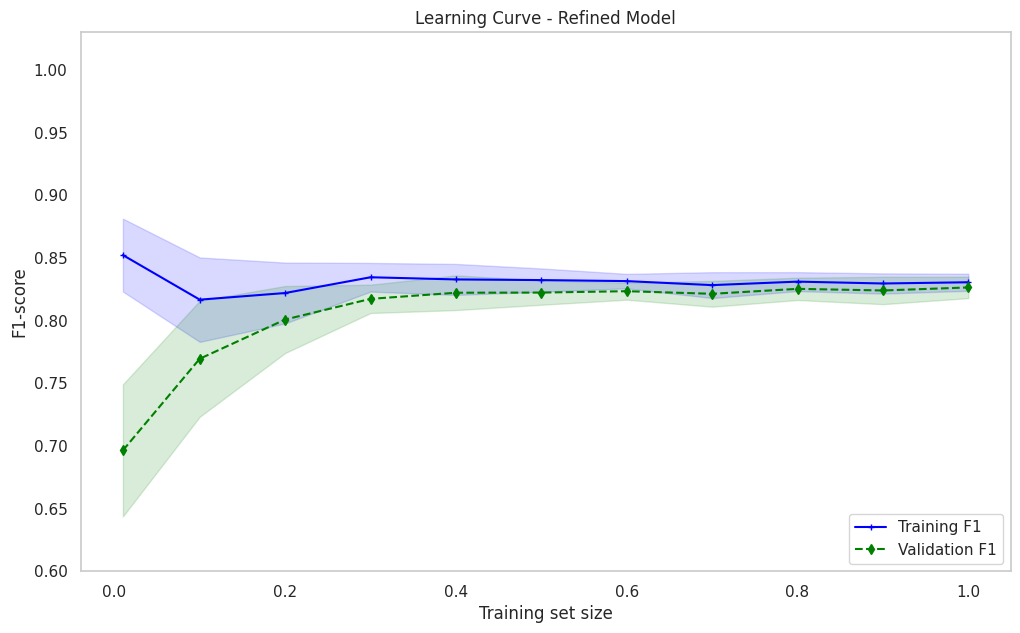

In [43]:
# means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Define train_sizes
train_sizes = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Plot of learning curve
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
        color='blue', marker='+',
        markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='d', markersize=5,
        label='Validation F1')

ax.fill_between(train_sizes,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])  
plt.title("Learning Curve - Refined Model")
plt.show()

The learning curve shows no significant overfitting. Initially, the training F1-score is higher than the validation F1-score, but as the training set size increases, the gap narrows. With the full dataset, both curves converge around 0.82–0.83, indicating good generalization. The shaded areas (variance) also shrink with more data, showing stable performance. Overall, the model achieves a good balance without clear signs of overfitting or underfitting.

### Confusion matrix

A confusion matrix is a table used to evaluate the performance of a classification model. It compares the predicted labels to the true lab elsfrom the dataset. The matrix is particularly useful for understanding the types of errors a model is making.

Confusion Matrix (values):
[[273 314]
 [199 1214]]


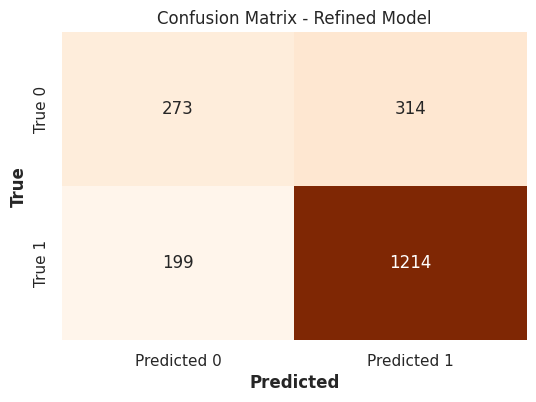

In [44]:
# best refined model
cls = rs_best.best_estimator_

# prediction on test set
y_pred = cls.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (values):")
print(f"[[{tn} {fp}]\n [{fn} {tp}]]")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Oranges', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title("Confusion Matrix - Refined Model")
plt.show()



The confusion matrix shows that the Logistic Regression model achieves balanced performance across both classes.  
There are still a significant number of false positives and false negatives, but overall the model correctly classifies the majority of instances, maintaining a reasonable balance between precision and recal

### ROC Curve

It shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) as the model's decision threshold varies.

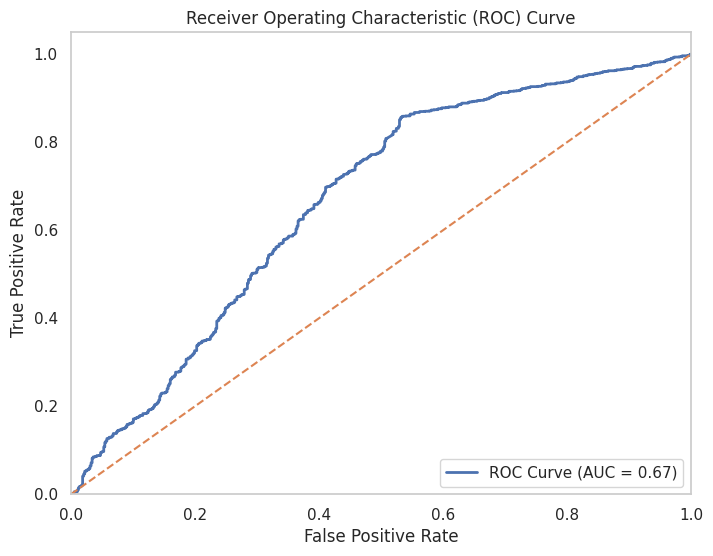

In [45]:
final_model = rs_best.best_estimator_  # model refined
final_model.fit(X_train, y_train)      

if hasattr(final_model, "predict_proba"):
    y_score = final_model.predict_proba(X_test)[:, 1]
else:
    y_score = final_model.decision_function(X_test)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)  # == roc_auc_score(y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Precision-Recall curve

It shows the trade-off between precision (accuracy of positive predictions) and recall (ability to find all positives) as the model's decision threshold varies. It's often more informative on imbalanced datasets such as mine.

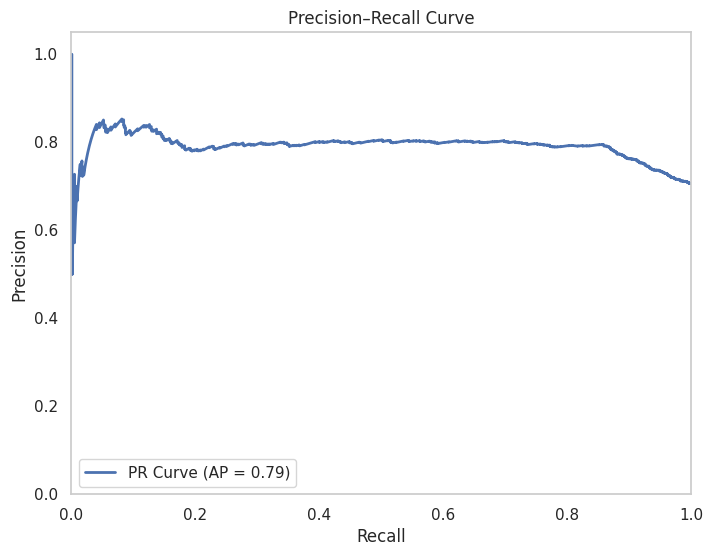

In [46]:
final_model = rs_best.best_estimator_
final_model.fit(X_train, y_train)

# probabilistic scores
if hasattr(final_model, "predict_proba"):
    y_score = final_model.predict_proba(X_test)[:, 1]
else:
    y_score = final_model.decision_function(X_test)

prec, rec, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(rec, prec, lw=2, label=f'PR Curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


The Precision-Recall curve illustrates the trade-off whereby an increase in recall (capturing more true positives) is achieved at the expense of a decrease in precision. This decrease in precision occurs because to increase recall, the decision threshold must be lowered, which leads to an increase in false positives. This trade-off highlights the intrinsic difficulty in correctly classifying the minority class.

The ROC AUC is relatively low (0.67) because the dataset is biased toward the majority class (71% True), and this metric, influenced by true negatives, penalizes the perception of the model's performance on the minority class, which the PR curve (AP=0.79) evaluates as good.

## Conclusion

In conclusion, the selected pipeline with Logistic Regression (C=0.1, solver=liblinear) achieved consistent and reliable results.  
Cross-validation reported a mean F1 score of 0.833 ± 0.007, while the refined model confirmed similar performance on the held-out test set.  
The learning curve and ROC/PR analyses show limited overfitting and stable generalization. The confusion matrix highlights that, although there are still false positives and false negatives due to class imbalance, the overall performance demonstrates that the chosen approach is robust and well-suited to this dataset.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=648622b5-c64b-45e1-8b0d-28eb9ff53491' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>